In [16]:
using ModelingToolkit, DomainSets, Sophon, CairoMakie, Lux
using Optimization, OptimizationOptimJL

@parameters x, t
@variables θ₁(..), θ₂(..), w₁(..), w₂(..)
Dₜ = Differential(t)
Dₜ² = Differential(t)^2
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

f₁(x,t) = cos(t)*(1-sin(x))
f₂(x,t) = 2/π * cos(t) - π/2 * sin(x) * cos(t)

eqs = [
    Dₓ(θ₁(x,t)) - Dₓ²(w₁(x,t)) + Dₜ²(w₁(x,t)) + w₁(x,t) - w₂(x,t) ~ f₁(x,t),
    Dₓ(θ₂(x,t)) - Dₓ²(w₂(x,t)) + Dₜ²(w₂(x,t)) + w₂(x,t) - w₁(x,t) ~ f₂(x,t),
    Dₜ²(θ₁(x,t)) ~ Dₓ²(θ₁(x,t)) + Dₓ(w₁(x,t)) - θ₁(x,t),
    Dₜ²(θ₂(x,t)) ~ Dₓ²(θ₂(x,t)) + Dₓ(w₂(x,t)) - θ₂(x,t),
]

bcs = [
    θ₁(x, 0.0) ~ π/2*cos(x) + x - π/2,
    Dₜ(θ₁(x, 0.0)) ~ 0.0,
    w₁(x, 0.0) ~ π/2*sin(x),
    Dₜ(w₁(x, 0.0)) ~ 0.0,
    θ₂(x, 0.0) ~ cos(x) + 2/π * x - 1,
    Dₜ(θ₂(x, 0.0)) ~ 0.0,
    w₂(x, 0.0) ~ sin(x),
    Dₜ(w₂(x, 0.0)) ~ 0.0,
    θ₁(0.0, t) ~ 0.0,
    θ₁(π, t) ~ 0.0,
    w₁(0.0, t) ~ 0.0,
    w₁(π, t) ~ 0.0,
    θ₂(0.0, t) ~ 0.0,
    θ₂(π, t) ~ 0.0,
    w₂(0.0, t) ~ 0.0,
    w₂(π, t) ~ 0.0]

    
domains = [x ∈ Interval(0.0, π),
           t ∈ Interval(0.0, 1.0)]

@named timo_double = PDESystem(eqs, bcs, domains, [x,t], [θ₁,θ₂,w₁,w₂])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(w₁(x, t))) + Differential(x)(θ₁(x, t)) + w₁(x, t) - Differential(x)(Differential(x)(w₁(x, t))) - w₂(x, t) ~ (1 - sin(x))*cos(t), Differential(t)(Differential(t)(w₂(x, t))) + Differential(x)(θ₂(x, t)) + w₂(x, t) - Differential(x)(Differential(x)(w₂(x, t))) - w₁(x, t) ~ 0.6366197723675814cos(t) - 1.5707963267948966cos(t)*sin(x), Differential(t)(Differential(t)(θ₁(x, t))) ~ Differential(x)(Differential(x)(θ₁(x, t))) + Differential(x)(w₁(x, t)) - θ₁(x, t), Differential(t)(Differential(t)(θ₂(x, t))) ~ Differential(x)(Differential(x)(θ₂(x, t))) + Differential(x)(w₂(x, t)) - θ₂(x, t)]
Boundary Conditions: Equation[θ₁(x, 0.0) ~ x + 1.5707963267948966cos(x) - 1.5707963267948966, Differential(t)(θ₁(x, 0.0)) ~ 0.0, w₁(x, 0.0) ~ 1.5707963267948966sin(x), Differential(t)(w₁(x, 0.0)) ~ 0.0, θ₂(x, 0.0) ~ 0.6366197723675814x + cos(x) - 1, Differential(t)(θ₂(x, 0.0)) ~ 0.0, w₂(x, 0.0) ~ sin(x), Differential(t)(w₂(x, 0.0)) ~ 0.0, θ₁(0.0, t) ~

In [17]:
pinn = PINN(θ₁ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            θ₂ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            w₁ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            w₂ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1))

sampler = QuasiRandomSampler(2000, 500)
strategy = NonAdaptiveTraining(1, 10)

prob = Sophon.discretize(timo_double, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(θ₁ = (layer_1 = (weight = [-0.40679049491882324 -0.06941556930541992; -0.033619701862335205 0.19977039098739624; … ; 0.23553550243377686 -0.48516666889190674; -0.10317927598953247 0.3670007586479187], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.26913562417030334 0.24725890159606934 … 0.0751800537109375 -0.3486098349094391; -0.24230173230171204 0.4124480187892914 … 0.44783326983451843 -0.2522532343864441; … ; -0.2407858669757843 0.35609203577041626 … 0.4278322160243988 0.33957594633102417; 0.3919776678085327 -0.12697243690490723 … 0.4084819257259369 -0.02673591487109661], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.06881769746541977 0.45272815227508545 … 0.0744585171341896 -0.12980814278125763; 0.5762389302253723 -0.5881596803665161 … 0.5079026818275452 -0.2438454031944275; … ; 0.6092303395271301 -0.5541239976882935 … -0.16043752431869507 0.14571909606456757; -0.45503365993499756 -0.186248168

In [18]:

iter = ProgressBar(1:1000)

function callback(p, l)
    set_description(iter, string(@sprintf("Loss: %.2f", l)))
    return false
end

bfgs = BFGS()

@time res = Optimization.solve(prob, bfgs; maxiters=1000, callback=callback)

Loss: 100.21799578910638


Loss: 37.51771066000177


Loss: 19.450019355481825


Loss: 14.313577741151546


Loss: 11.866450899867784


Loss: 10.636236891212292


Loss: 8.175851143780875


Loss: 6.298727714466209


Loss: 5.5361373197197725


Loss: 4.921854904894982


Loss: 4.03233021457054


Loss: 3.251832610440916


Loss: 2.29716671106185


Loss: 2.0643733328936205


Loss: 1.7887196394867788


Loss: 1.615841229872048


Loss: 1.5295431053641457


Loss: 1.2503433672306445


Loss: 1.0603066055178128


Loss: 0.8766754709613411


Loss: 0.8101929084322402


Loss: 0.7820529094132276


Loss: 0.7343276581783278


Loss: 0.7126122059474087


Loss: 0.658433435065953


Loss: 0.5754106598270234


Loss: 0.4875574077845084


Loss: 0.4682908453249832


Loss: 0.40105652529190533


Loss: 0.3430956523902473


Loss: 0.28596422326610427


Loss: 0.23961434536684778


Loss: 0.21366002525921826


Loss: 0.1928376888297082


Loss: 0.17894767163039607


Loss: 0.15485088139502928


Loss: 0.1369097918502865


Loss: 0.12187655466799609


Loss: 0.11621408923941491


Loss: 0.11217333568556814


Loss: 0.09583964958872425


Loss: 0.09305789319002361


Loss: 0.08392435571993109


Loss: 0.08144297308844975


Loss: 0.07856868324789527


Loss: 0.07376716659204366


Loss: 0.06760013482571071


Loss: 0.06354313359052177


Loss: 0.05753725302252339


Loss: 0.055326462900098836


Loss: 0.047567502462783975


Loss: 0.046606313718084276


Loss: 0.04566773167566262


Loss: 0.04253282716066592


Loss: 0.03999617071448534


Loss: 0.034613883727606


Loss: 0.03315756799038147


Loss: 0.030737568534095188


Loss: 0.02952009520589539


Loss: 0.024473889111742187


Loss: 0.021374923586036355


Loss: 0.020190412473980002


Loss: 0.018865897884707224


Loss: 0.01741406600227741


Loss: 0.01659599793495031


Loss: 0.015586126350789575


Loss: 0.014898515390343092


Loss: 0.014220534425581308


Loss: 0.013554964457079922


Loss: 0.012882209227071284


Loss: 0.012560258952450028


Loss: 0.011735948152517233


Loss: 0.011369677728915867


Loss: 0.010951616521369296


Loss: 0.010379036583725685


Loss: 0.010063243190581479


Loss: 0.009696881503569706


Loss: 0.008967480280995027


Loss: 0.008731823622143944


Loss: 0.008401959372077657


Loss: 0.008130109747175485


Loss: 0.007685059972627722


Loss: 0.007434858796151603


Loss: 0.007065417393131738


Loss: 0.00682585109624163


Loss: 0.006490208733353878


Loss: 0.006327902022035776


Loss: 0.006166033943877637


Loss: 0.005993655219542486


Loss: 0.005700223626047229


Loss: 0.005512357661912359


Loss: 0.005211218673088444


Loss: 0.005026220766000295


Loss: 0.004801654188739056


Loss: 0.0046346340003250615


Loss: 0.004485863084072563


Loss: 0.004184837223247075


Loss: 0.0040573394654480335


Loss: 0.0039051850875081234


Loss: 0.0038151033416850425


Loss: 0.0037103366071746273


Loss: 0.0036279515384211583


Loss: 0.0034933384003245998


Loss: 0.0033306864613055942


Loss: 0.0032050591741046336


Loss: 0.0029907351540011426


Loss: 0.0028848042693503575


Loss: 0.0027125289179091455


Loss: 0.0025670295713390652


Loss: 0.002422316332338723


Loss: 0.002287477969744795


Loss: 0.0021368265203544077


Loss: 0.0020483857106044848


Loss: 0.0019754710642328165


Loss: 0.0018550379140489192


Loss: 0.001797567365633401


Loss: 0.0017410560313479487


Loss: 0.0016858495937628426


Loss: 0.0016301415321937416


Loss: 0.0015898951993547886


Loss: 0.001548539822076492


Loss: 0.0015051149655052158


Loss: 0.0014605643708393398


Loss: 0.001412404092398968


Loss: 0.0013608019406391877


Loss: 0.001314482607835737


Loss: 0.0012505979000935437


Loss: 0.0011939329649338182


Loss: 0.001122276677218979


Loss: 0.001094623848312687


Loss: 0.0010468702281570793


Loss: 0.0010061404158486858


Loss: 0.0009854315680099673


Loss: 0.0009591411143893833


Loss: 0.0009389869779724582


Loss: 0.0009150392014276729


Loss: 0.0008876602390332052


Loss: 0.0008505631462504214


Loss: 0.000814873394992303


Loss: 0.0007830243982767805


Loss: 0.0007390130870093964


Loss: 0.0007057413708461845


Loss: 0.000680814262652499


Loss: 0.0006599021090893132


Loss: 0.0006396416476324262


Loss: 0.0006015195650152674


Loss: 0.0005833065978749928


Loss: 0.0005672137574135449


Loss: 0.0005522721541871907


Loss: 0.0005360690630248481


Loss: 0.000527699192984772


Loss: 0.0005188623820324446


Loss: 0.0005093396992748142


Loss: 0.0004970504442032672


Loss: 0.00048383028093971386


Loss: 0.00047494378862421614


Loss: 0.000461581179554583


Loss: 0.0004490119472455371


Loss: 0.00043630575712661846


Loss: 0.00042527181688247173


Loss: 0.00041363459891330655


Loss: 0.00039994569372169393


Loss: 0.00038362665571790996


Loss: 0.0003693988460473221


Loss: 0.0003575365306302667


Loss: 0.00034568568928452836


Loss: 0.0003357186997814127


Loss: 0.0003270696410947405


Loss: 0.0003192283436875055


Loss: 0.0003108851305866448


Loss: 0.00030217673954974574


Loss: 0.0002940476759960012


Loss: 0.0002821044291224729


Loss: 0.0002719247190617708


Loss: 0.00026294993717396143


Loss: 0.0002556500507527301


Loss: 0.00025053552290548885


Loss: 0.0002462402796856025


Loss: 0.00024142228164741777


Loss: 0.00023811388414874882


Loss: 0.0002336306577034977


Loss: 0.0002285843507855749


Loss: 0.00022457759499860537


Loss: 0.000221414304541002


Loss: 0.00021758805255237242


Loss: 0.00021229002024423943


Loss: 0.00020839914987984528


Loss: 0.00020372002322594342


Loss: 0.0001997712966209567


Loss: 0.0001969063629719196


Loss: 0.00019413797570379333


Loss: 0.00019227293378911827


Loss: 0.00018951133133913593


Loss: 0.00018704567243627994


Loss: 0.00018352898417503844


Loss: 0.00017891526881717862


Loss: 0.0001752154910831165


Loss: 0.00017073145254271045


Loss: 0.00016746691350091577


Loss: 0.00016468393505259064


Loss: 0.0001608410742071984


Loss: 0.00015779432829988744


Loss: 0.00015321448295319


Loss: 0.00015045526595399369


Loss: 0.00014738775256191208


Loss: 0.00014406499109631042


Loss: 0.00014130819163004133


Loss: 0.00013798512452018868


Loss: 0.0001343883189699301


Loss: 0.00012984477549778076


Loss: 0.0001264540847515847


Loss: 0.00012395665002004155


Loss: 0.0001213745128120951


Loss: 0.00011820145652547296


Loss: 0.00011634573134093384


Loss: 0.00011417679843390429


Loss: 0.00011280278186379229


Loss: 0.00011103898171460557


Loss: 0.00010880962145269903


Loss: 0.00010705154733033199


Loss: 0.00010494157592586869


Loss: 0.00010354289316484949


Loss: 0.00010196229072651906


Loss: 0.00010060296772018961


Loss: 9.921016759423735e-5


Loss: 9.776860131037789e-5


Loss: 9.617740477393281e-5


Loss: 9.502593610230568e-5


Loss: 9.317165983490493e-5


Loss: 9.168983427952759e-5


Loss: 8.965946205364649e-5


Loss: 8.776360003681062e-5


Loss: 8.615743483339505e-5


Loss: 8.450549298055085e-5


Loss: 8.314642905142914e-5


Loss: 8.135927512143965e-5


Loss: 7.982785564195984e-5


Loss: 7.830936741197027e-5


Loss: 7.697744686539701e-5


Loss: 7.590648752371934e-5


Loss: 7.516526530067725e-5


Loss: 7.443420754487208e-5


Loss: 7.360485975601391e-5


Loss: 7.251709057242545e-5


Loss: 7.140497104876148e-5


Loss: 7.05756777407434e-5


Loss: 6.976004111085299e-5


Loss: 6.885511511611756e-5


Loss: 6.791438939270853e-5


Loss: 6.692835470300356e-5


Loss: 6.536998460188892e-5


Loss: 6.436152644699008e-5


Loss: 6.352333375915413e-5


Loss: 6.286132473370632e-5


Loss: 6.23799148323733e-5


Loss: 6.194707298163299e-5


Loss: 6.132926590129395e-5


Loss: 6.049029306300244e-5


Loss: 5.959794693421284e-5


Loss: 5.883429027860794e-5


Loss: 5.8121905384844456e-5


Loss: 5.7413756443196656e-5


Loss: 5.688315493456582e-5


Loss: 5.63847634981244e-5


Loss: 5.5813539420040966e-5


Loss: 5.506134578165762e-5


Loss: 5.4368712890422806e-5


Loss: 5.384220170157691e-5


Loss: 5.342712384771439e-5


Loss: 5.303566894555536e-5


Loss: 5.2499811342811796e-5


Loss: 5.1893820124496336e-5


Loss: 5.140266237821876e-5


Loss: 5.0807005728405146e-5


Loss: 5.0133481827496815e-5


Loss: 4.946684497815706e-5


Loss: 4.8878208538693775e-5


Loss: 4.8419431051934366e-5


Loss: 4.8032579198285264e-5


Loss: 4.7633161578935056e-5


Loss: 4.706981619405305e-5


Loss: 4.649743978947611e-5


Loss: 4.5900921526474945e-5


Loss: 4.5185072538783725e-5


Loss: 4.4663255919066635e-5


Loss: 4.4101496166391105e-5


Loss: 4.3668493104504314e-5


Loss: 4.326723288459041e-5


Loss: 4.281419224600927e-5


Loss: 4.238478971779943e-5


Loss: 4.19462325233983e-5


Loss: 4.16299959181253e-5


Loss: 4.1369437109871387e-5


Loss: 4.1116577683005806e-5


Loss: 4.0839879557568515e-5


Loss: 4.044906108077634e-5


Loss: 4.008805114172051e-5


Loss: 3.9731974854796425e-5


Loss: 3.9389828462138727e-5


Loss: 3.899965871727702e-5


Loss: 3.847872490230319e-5


Loss: 3.793836509249418e-5


Loss: 3.749338357041258e-5


Loss: 3.718215019089437e-5


Loss: 3.683080002257479e-5


Loss: 3.650203492960755e-5


Loss: 3.614748361311571e-5


Loss: 3.5822209084716775e-5


Loss: 3.5480756495474044e-5


Loss: 3.521435556591941e-5


Loss: 3.49987201220807e-5


Loss: 3.4838640546906885e-5


Loss: 3.4543749547690325e-5


Loss: 3.408125519343745e-5


Loss: 3.3668156139787464e-5


Loss: 3.3359210384728265e-5


Loss: 3.302844180800657e-5


Loss: 3.277689191611687e-5


Loss: 3.25422546755442e-5


Loss: 3.2323328530227716e-5


Loss: 3.202321614736189e-5


Loss: 3.178043178563008e-5


Loss: 3.155384668574826e-5


Loss: 3.132838286874197e-5


Loss: 3.099614766295801e-5


Loss: 3.070054441309022e-5


Loss: 3.051373802507453e-5


Loss: 3.0285722521463797e-5


Loss: 3.0048082098179896e-5


Loss: 2.975013670098925e-5


Loss: 2.9351404038031396e-5


Loss: 2.8916754737769307e-5


Loss: 2.8376866823865217e-5


Loss: 2.7784173458919524e-5


Loss: 2.7294573240189054e-5


Loss: 2.6887528138235617e-5


Loss: 2.6620139657120167e-5


Loss: 2.6465982315937954e-5


Loss: 2.6344827773944347e-5


Loss: 2.622297299348194e-5


Loss: 2.6016330959267756e-5


Loss: 2.5668471341985887e-5


Loss: 2.5283616298120466e-5


Loss: 2.480895862567692e-5


Loss: 2.457334621715471e-5


Loss: 2.4400457654915694e-5


Loss: 2.4266462939100883e-5


Loss: 2.417967900422617e-5


Loss: 2.4093571883342668e-5


Loss: 2.4012542157891315e-5


Loss: 2.3884316100344075e-5


Loss: 2.3712181017428832e-5


Loss: 2.3401373854201023e-5


Loss: 2.307377420804993e-5


Loss: 2.2931260158187264e-5


Loss: 2.2845311106508518e-5


Loss: 2.2748147291896412e-5


Loss: 2.2680402257554726e-5


Loss: 2.258977031935205e-5


Loss: 2.2500232366824158e-5


Loss: 2.2381069491854784e-5


Loss: 2.2264036020476707e-5


Loss: 2.213588433899259e-5


Loss: 2.1981769350362512e-5


Loss: 2.1811025568621153e-5


Loss: 2.1626359304722052e-5


Loss: 2.1445763057312583e-5


Loss: 2.1324864540239675e-5


Loss: 2.1197054951882075e-5


Loss: 2.1059902291626366e-5


Loss: 2.0891533853424595e-5


Loss: 2.0721653511356555e-5


Loss: 2.043652251116686e-5


Loss: 2.0125139637354195e-5


Loss: 1.990941372123528e-5


Loss: 1.9738002027073167e-5


Loss: 1.9572584084375777e-5


Loss: 1.9405999051249086e-5


Loss: 1.926207546853919e-5


Loss: 1.91045819872094e-5


Loss: 1.893246568628074e-5


Loss: 1.8739122779834898e-5


Loss: 1.8545784346848077e-5


Loss: 1.8364796498233467e-5


Loss: 1.821948697308625e-5


Loss: 1.8077792766753577e-5


Loss: 1.7987866547747497e-5


Loss: 1.7914264673168444e-5


Loss: 1.7853119998236056e-5


Loss: 1.778866208521081e-5


Loss: 1.772571886824554e-5


Loss: 1.7659072069889104e-5


Loss: 1.7575504262896366e-5


Loss: 1.7434374026265447e-5


Loss: 1.729255965452269e-5


Loss: 1.716667347023456e-5


Loss: 1.7056192892900804e-5


Loss: 1.6959846757815234e-5


Loss: 1.6870625356269233e-5


Loss: 1.6755390165971866e-5


Loss: 1.6643408059780772e-5


Loss: 1.652058422629235e-5


Loss: 1.6423924330016938e-5


Loss: 1.6304100183016846e-5


Loss: 1.6221826178050126e-5


Loss: 1.615133270550886e-5


Loss: 1.605575973741597e-5


Loss: 1.5944758235205883e-5


Loss: 1.583058143690213e-5


Loss: 1.569396273965311e-5


Loss: 1.5551227346592714e-5


Loss: 1.5442545517250383e-5


Loss: 1.5356317338394667e-5


Loss: 1.5273891747383622e-5


Loss: 1.5218476162548566e-5


Loss: 1.516374273202745e-5


Loss: 1.5102659272046355e-5


Loss: 1.5022648182167624e-5


Loss: 1.4926173141024696e-5


Loss: 1.4811406350103987e-5


Loss: 1.4692011877056512e-5


Loss: 1.4589257614711683e-5


Loss: 1.4525198960924266e-5


Loss: 1.4484116976346304e-5


Loss: 1.4442542965034245e-5


Loss: 1.4402001804829685e-5


Loss: 1.4325673317771874e-5


Loss: 1.4249586068317873e-5


Loss: 1.4152440018128427e-5


Loss: 1.4084473880239744e-5


Loss: 1.4008617308993785e-5


Loss: 1.3941410996483124e-5


Loss: 1.3853250112124745e-5


Loss: 1.3724875573474336e-5


Loss: 1.3612284306644082e-5


Loss: 1.3523351526858235e-5


Loss: 1.3472357828261031e-5


Loss: 1.3422450830761394e-5


Loss: 1.3375399860253119e-5


Loss: 1.3333723481191752e-5


Loss: 1.3282452228714004e-5


Loss: 1.3230527536232387e-5


Loss: 1.3172985762641747e-5


Loss: 1.3138654667536597e-5


Loss: 1.3098337670944094e-5


Loss: 1.3041647301780901e-5


Loss: 1.294558227375667e-5


Loss: 1.2859693423580295e-5


Loss: 1.2764412131661023e-5


Loss: 1.2638634677738296e-5


Loss: 1.2553844486389222e-5


Loss: 1.2488788405621112e-5


Loss: 1.241838169133215e-5


Loss: 1.2359246074661766e-5


Loss: 1.2334493716360406e-5


Loss: 1.229571518620996e-5


Loss: 1.2268830373303409e-5


Loss: 1.223583903375394e-5


Loss: 1.2208983034636004e-5


Loss: 1.2180275702496965e-5


Loss: 1.2141828027416435e-5


Loss: 1.209120034313225e-5


Loss: 1.2027830614139989e-5


Loss: 1.1961871145735112e-5


Loss: 1.1911007656977938e-5


Loss: 1.1873073023112843e-5


Loss: 1.183925481527856e-5


Loss: 1.180580802704846e-5


Loss: 1.1773477735584101e-5


Loss: 1.1724550029950303e-5


Loss: 1.1658455036991556e-5


Loss: 1.1569469386063065e-5


Loss: 1.1464005263694834e-5


Loss: 1.1350773001686245e-5


Loss: 1.1222666030741484e-5


Loss: 1.1115961765696071e-5


Loss: 1.1016649207749607e-5


Loss: 1.0951136440053189e-5


Loss: 1.0891550083225269e-5


Loss: 1.0862838737978954e-5


Loss: 1.0834248273914262e-5


Loss: 1.0795006671646628e-5


Loss: 1.0760107641880764e-5


Loss: 1.073364906779378e-5


Loss: 1.069202781603397e-5


Loss: 1.0647252962414592e-5


Loss: 1.0600192798772768e-5


Loss: 1.0501917610651295e-5


Loss: 1.0420770870832752e-5


Loss: 1.0340591017319887e-5


Loss: 1.0260328902607035e-5


Loss: 1.0221338018938927e-5


Loss: 1.0156036881873829e-5


Loss: 1.0112784363002224e-5


Loss: 1.0062936317889395e-5


Loss: 1.001127782007026e-5


Loss: 9.972855392348816e-6


Loss: 9.906247533562137e-6


Loss: 9.860114861624967e-6


Loss: 9.816905492711665e-6


Loss: 9.776118478744228e-6


Loss: 9.735498341181877e-6


Loss: 9.697832751867217e-6


Loss: 9.671089313760744e-6


Loss: 9.6406653750494e-6


Loss: 9.604026181293456e-6


Loss: 9.556390295620297e-6


Loss: 9.482168279273801e-6


Loss: 9.395054555822554e-6


Loss: 9.294642866734567e-6


Loss: 9.222365259859853e-6


Loss: 9.17497069317052e-6


Loss: 9.130934911808515e-6


Loss: 9.100550806144734e-6


Loss: 9.073935664894618e-6


Loss: 9.04576156109423e-6


Loss: 9.007690396829302e-6


Loss: 8.977750285040094e-6


Loss: 8.944856859007855e-6


Loss: 8.914552736209646e-6


Loss: 8.887344786774875e-6


Loss: 8.86636793220972e-6


Loss: 8.842079692734838e-6


Loss: 8.810219264905525e-6


Loss: 8.774672224839205e-6


Loss: 8.717456884838742e-6


Loss: 8.643563222450967e-6


Loss: 8.547432808391538e-6


Loss: 8.47364223873523e-6


Loss: 8.41524219936501e-6


Loss: 8.35927646748313e-6


Loss: 8.30340072258128e-6


Loss: 8.261974537740973e-6


Loss: 8.234372991956871e-6


Loss: 8.207915935563778e-6


Loss: 8.185098233159053e-6


Loss: 8.162618979344843e-6


Loss: 8.125543407070834e-6


Loss: 8.078392095870703e-6


Loss: 8.01742484065643e-6


Loss: 7.946562844502577e-6


Loss: 7.866689511698145e-6


Loss: 7.775346396375084e-6


Loss: 7.70530403435534e-6


Loss: 7.672639074400223e-6


Loss: 7.640339125326848e-6


Loss: 7.61098330310901e-6


Loss: 7.583085385033257e-6


Loss: 7.5571123942047345e-6


Loss: 7.5355007893549605e-6


Loss: 7.5094010894454365e-6


Loss: 7.479133028115846e-6


Loss: 7.452090631329313e-6


Loss: 7.4312076409677486e-6


Loss: 7.406945497805597e-6


Loss: 7.3850636889403e-6


Loss: 7.363243662065665e-6


Loss: 7.339763234591569e-6


Loss: 7.318482686753256e-6


Loss: 7.2956441395861055e-6


Loss: 7.265281812666159e-6


Loss: 7.234290662846575e-6


Loss: 7.197067268424435e-6


Loss: 7.1700796135168026e-6


Loss: 7.130170917716013e-6


Loss: 7.095810136323131e-6


Loss: 7.07494054224704e-6


Loss: 7.0507903155939954e-6


Loss: 7.026131115952688e-6


Loss: 7.008929712151602e-6


Loss: 6.988587204267566e-6


Loss: 6.969934531974083e-6


Loss: 6.936349017016211e-6


Loss: 6.90414966642184e-6


Loss: 6.8754195068377085e-6


Loss: 6.844473756974448e-6


Loss: 6.820279265756207e-6


Loss: 6.800848980559504e-6


Loss: 6.788356677142869e-6


Loss: 6.7781092470895565e-6


Loss: 6.770218542573408e-6


Loss: 6.7640491199813986e-6


Loss: 6.753748174921361e-6


Loss: 6.738210755765421e-6


Loss: 6.722357202612103e-6


Loss: 6.708203241662852e-6


Loss: 6.685727224458522e-6


Loss: 6.649388446774897e-6


Loss: 6.608756452261221e-6


Loss: 6.572787174134772e-6


Loss: 6.543197200568796e-6


Loss: 6.4900111123234135e-6


Loss: 6.4440064831271375e-6


Loss: 6.3983226199509616e-6


Loss: 6.3690318393116085e-6


Loss: 6.3522006503807e-6


Loss: 6.340049016331029e-6


Loss: 6.327590589259386e-6


Loss: 6.315907438576242e-6


Loss: 6.303562388879954e-6


Loss: 6.287993400735769e-6


Loss: 6.266836093958948e-6


Loss: 6.235502792287379e-6


Loss: 6.202516992848907e-6


Loss: 6.1577888499818275e-6


Loss: 6.114401587354858e-6


Loss: 6.06781796545991e-6


Loss: 6.030037183086452e-6


Loss: 6.002350996016863e-6


Loss: 5.9635487706928715e-6


Loss: 5.9204461515227925e-6


Loss: 5.874699487406971e-6


Loss: 5.828155719308833e-6


Loss: 5.790803390095385e-6


Loss: 5.758956107991248e-6


Loss: 5.736809275391597e-6


Loss: 5.718837120978923e-6


Loss: 5.7050650104440695e-6


Loss: 5.696089192941868e-6


Loss: 5.683131652269591e-6


Loss: 5.67065983524951e-6


Loss: 5.657143915922793e-6


Loss: 5.642705327663242e-6


Loss: 5.628800119445765e-6


Loss: 5.6054775352013045e-6


Loss: 5.581480640458003e-6


Loss: 5.5411027124308195e-6


Loss: 5.4992093223853106e-6


Loss: 5.464932493669184e-6


Loss: 5.428497898267879e-6


Loss: 5.3934370786373516e-6


Loss: 5.351148949720261e-6


Loss: 5.309459722188865e-6


Loss: 5.26805416637302e-6


Loss: 5.232270178455745e-6


Loss: 5.192132130942236e-6


Loss: 5.161293196002356e-6


Loss: 5.131720657909202e-6


Loss: 5.0967393007481525e-6


Loss: 5.066348368641775e-6


Loss: 5.034509030573353e-6


Loss: 5.004186340623163e-6


Loss: 4.96026431694604e-6


Loss: 4.914208167398492e-6


Loss: 4.8598877084981855e-6


Loss: 4.810991964989882e-6


Loss: 4.771519635647523e-6


Loss: 4.735825348115632e-6


Loss: 4.714164703080654e-6


Loss: 4.685243997816373e-6


Loss: 4.6624046056994545e-6


Loss: 4.650632160212785e-6


Loss: 4.632314599647882e-6


Loss: 4.620357409146933e-6


Loss: 4.600656644363586e-6


Loss: 4.5824353428730776e-6


Loss: 4.5655132127708955e-6


Loss: 4.546185997477395e-6


Loss: 4.529646579789629e-6


Loss: 4.513893127057805e-6


Loss: 4.497562670419845e-6


Loss: 4.484859432327112e-6


Loss: 4.470792286620017e-6


Loss: 4.454231229854934e-6


Loss: 4.4360905789281974e-6


Loss: 4.4160926314353275e-6


Loss: 4.397701392759626e-6


Loss: 4.383346988084565e-6


Loss: 4.372329465606741e-6


Loss: 4.3540572589326164e-6


Loss: 4.3399011882508296e-6


Loss: 4.325664626628883e-6


Loss: 4.31135493201836e-6


Loss: 4.299307848524399e-6


Loss: 4.287253907168772e-6


Loss: 4.273183963405558e-6


Loss: 4.2555290919285395e-6


Loss: 4.239149253748778e-6


Loss: 4.2227843185359225e-6


Loss: 4.20943895151527e-6


Loss: 4.192434811781353e-6


Loss: 4.176918328436003e-6


Loss: 4.1651003618904e-6


Loss: 4.153176309020478e-6


Loss: 4.134986805431096e-6


Loss: 4.1148957347128e-6


Loss: 4.087089084156989e-6


Loss: 4.063458246769895e-6


Loss: 4.048198531128811e-6


Loss: 4.034693485297412e-6


Loss: 4.018956098300044e-6


Loss: 4.004180312685242e-6


Loss: 3.989731013112033e-6


Loss: 3.976440147492122e-6


Loss: 3.966562714907937e-6


Loss: 3.95803723416661e-6


Loss: 3.950207450393041e-6


Loss: 3.940210396027919e-6


Loss: 3.927432826081932e-6


Loss: 3.911722727464384e-6


Loss: 3.899129926875241e-6


Loss: 3.88252821956723e-6


Loss: 3.8590020920076455e-6


Loss: 3.835674047446787e-6


Loss: 3.8102471459011615e-6


Loss: 3.781997043530366e-6


Loss: 3.757030281767991e-6


Loss: 3.729945075638679e-6


Loss: 3.698338198163805e-6


Loss: 3.6662635190530686e-6


Loss: 3.644434299299946e-6


Loss: 3.627117312913992e-6


Loss: 3.613299692864419e-6


Loss: 3.6047234109466914e-6


Loss: 3.5968984498733494e-6


Loss: 3.5895816825770646e-6


Loss: 3.5832316433615115e-6


Loss: 3.5765051399308025e-6


Loss: 3.566370510642186e-6


Loss: 3.557509503752386e-6


Loss: 3.5442819737941885e-6


Loss: 3.530723195455331e-6


Loss: 3.5206022735755046e-6


Loss: 3.511559017890396e-6


Loss: 3.500296648599337e-6


Loss: 3.491861760899762e-6


Loss: 3.4828444500372436e-6


Loss: 3.4719792903314177e-6


Loss: 3.4628255456697302e-6


Loss: 3.452735846784408e-6


Loss: 3.4400257561061556e-6


Loss: 3.428108199097908e-6


Loss: 3.4148222375347247e-6


Loss: 3.3985684254854148e-6


Loss: 3.384431418502544e-6


Loss: 3.3679690700777403e-6


Loss: 3.3522131219543668e-6


Loss: 3.3309109306447558e-6


Loss: 3.3123483729779272e-6


Loss: 3.294573473221222e-6


Loss: 3.276197808419665e-6


Loss: 3.259424193710258e-6


Loss: 3.232481672107581e-6


Loss: 3.212884156105039e-6


Loss: 3.1980643858391333e-6


Loss: 3.1827447255921196e-6


Loss: 3.164412916147589e-6


Loss: 3.1422341925118096e-6


Loss: 3.120962067292429e-6


Loss: 3.0916171841007785e-6


Loss: 3.0616332432081474e-6


Loss: 3.005707881432738e-6


Loss: 2.9650993059539506e-6


Loss: 2.9325529954902436e-6


Loss: 2.90918281530717e-6


Loss: 2.8902273283556483e-6


Loss: 2.8798737519249734e-6


Loss: 2.8718133239725775e-6


Loss: 2.866049254491938e-6


Loss: 2.8601287683891245e-6


Loss: 2.853293225215404e-6


Loss: 2.8462759491358815e-6


Loss: 2.839836072956624e-6


Loss: 2.8337984389503586e-6


Loss: 2.8281236000912226e-6


Loss: 2.821904325208187e-6


Loss: 2.813895523572839e-6


Loss: 2.804646973737766e-6


Loss: 2.791828149038457e-6


Loss: 2.778027330405782e-6


Loss: 2.757971447064178e-6


Loss: 2.7327139688559484e-6


Loss: 2.701594704438355e-6


Loss: 2.6637340752837866e-6


Loss: 2.619249157130085e-6


Loss: 2.5908226221649283e-6


Loss: 2.573025688798671e-6


Loss: 2.555470468696468e-6


Loss: 2.5396519067666985e-6


Loss: 2.5268465521888574e-6


Loss: 2.51593530781218e-6


Loss: 2.5057438889089425e-6


Loss: 2.4933231494970338e-6


Loss: 2.483277443102678e-6


Loss: 2.474258814026832e-6


Loss: 2.4630338938364137e-6


Loss: 2.4520817641273532e-6


Loss: 2.4448027318263083e-6


Loss: 2.439120513545497e-6


Loss: 2.4317556469705502e-6


Loss: 2.423293052797901e-6


Loss: 2.4125846700501864e-6


Loss: 2.4018075167404315e-6


Loss: 2.3935614991375705e-6


Loss: 2.3875108629612336e-6


Loss: 2.3798881351257833e-6


Loss: 2.3688709267114387e-6


Loss: 2.3563795105195243e-6


Loss: 2.345502175998056e-6


Loss: 2.3371003163792454e-6


Loss: 2.329094545684644e-6


Loss: 2.3222290595759316e-6


Loss: 2.313550234612432e-6


Loss: 2.3046646477437363e-6


Loss: 2.291648596889268e-6


Loss: 2.2787070864133254e-6


Loss: 2.268551127217795e-6


Loss: 2.258896626719251e-6


Loss: 2.2529610136581893e-6


Loss: 2.2472726335991735e-6


Loss: 2.2417494448865884e-6


Loss: 2.2361183156021605e-6


Loss: 2.2306775738258863e-6


Loss: 2.225047290220857e-6


Loss: 2.2192828948966895e-6


Loss: 2.2132208042083086e-6


Loss: 2.2075368448777644e-6


Loss: 2.2027202389599793e-6


Loss: 2.2001764556967294e-6


Loss: 2.1982695623674294e-6


Loss: 2.195681598255871e-6


Loss: 2.1925311081401644e-6


Loss: 2.1884123846446244e-6


Loss: 2.184762612081909e-6


Loss: 2.179937659731223e-6


Loss: 2.1736847585041096e-6


Loss: 2.166273663030557e-6


Loss: 2.155889972541154e-6


Loss: 2.1402731501273576e-6


Loss: 2.1240763614530185e-6


Loss: 2.1093022139756623e-6


Loss: 2.0929648021281846e-6


Loss: 2.079074709771962e-6


Loss: 2.070061967075033e-6


Loss: 2.06004658509419e-6


Loss: 2.048775187133515e-6


Loss: 2.0406735533887774e-6


Loss: 2.0317728726931987e-6


Loss: 2.0198156293042927e-6


Loss: 2.00449410610161e-6


Loss: 1.9886158617305224e-6


Loss: 1.9716325479310543e-6


Loss: 1.9608705961250883e-6


Loss: 1.9541742980058843e-6


Loss: 1.9467563308842053e-6


Loss: 1.939688020133804e-6


Loss: 1.931399914829786e-6


Loss: 1.9240425804229185e-6


Loss: 1.9172985889946397e-6


Loss: 1.908690302302926e-6


Loss: 1.9017056116898e-6


Loss: 1.8963473344977938e-6


Loss: 1.8898364529443716e-6


Loss: 1.8808371480393122e-6


Loss: 1.871784418914139e-6


Loss: 1.8591793917631329e-6


Loss: 1.844307625311259e-6


Loss: 1.8331610189808482e-6


Loss: 1.8229559308881066e-6


Loss: 1.8071851033826178e-6


Loss: 1.7923554480017882e-6


Loss: 1.7766798287525434e-6


Loss: 1.7658643367376265e-6


Loss: 1.7598846152518994e-6


Loss: 1.7551340149609058e-6


Loss: 1.7522038283289514e-6


Loss: 1.7493617671077808e-6


Loss: 1.746954058257487e-6


Loss: 1.7436006531354101e-6


Loss: 1.7396770377599987e-6


Loss: 1.735566713034165e-6


Loss: 1.7314873365858275e-6


Loss: 1.7267827175639029e-6


Loss: 1.7230340538944435e-6


Loss: 1.7189021721210709e-6


Loss: 1.7161450184361646e-6


Loss: 1.713746014444356e-6


Loss: 1.7105832426113034e-6


Loss: 1.7075319029472544e-6


Loss: 1.7019339091362379e-6


Loss: 1.69723384169132e-6


Loss: 1.69149292639352e-6


Loss: 1.682376179949802e-6


Loss: 1.6759272609091547e-6


Loss: 1.670327100823637e-6


Loss: 1.6636993070683248e-6


Loss: 1.657558582463907e-6


Loss: 1.6521119510564057e-6


Loss: 1.6480383197253936e-6


Loss: 1.6436419980607006e-6


Loss: 1.6379653358039812e-6


Loss: 1.6300984602347833e-6


Loss: 1.6202581293751742e-6


Loss: 1.60936136484488e-6


Loss: 1.6000649958985737e-6


Loss: 1.591984705452882e-6


Loss: 1.5843199611157188e-6


Loss: 1.576882871988776e-6


Loss: 1.5708196948399369e-6


Loss: 1.5664943531756601e-6


Loss: 1.5628575365059144e-6


Loss: 1.5604353386737838e-6


Loss: 1.558165032020856e-6


Loss: 1.5555970422019336e-6


Loss: 1.5529399091569967e-6


Loss: 1.5504364119428024e-6


Loss: 1.5481962723638077e-6


Loss: 1.5444176596973982e-6


Loss: 1.540224249542012e-6


Loss: 1.5347221893071746e-6


Loss: 1.5297993399912579e-6


Loss: 1.5261234146302047e-6


Loss: 1.5192102663323723e-6


Loss: 1.5087301933344402e-6


Loss: 1.4955504195020988e-6


Loss: 1.4843342804915012e-6


Loss: 1.474023018121047e-6


Loss: 1.4658304215242678e-6


Loss: 1.4600167237189251e-6


Loss: 1.451936829460489e-6


Loss: 1.439951206513181e-6


Loss: 1.428196501639096e-6


Loss: 1.4153806269955636e-6


Loss: 1.4070391932270184e-6


Loss: 1.4013587916468144e-6


Loss: 1.3967264290869119e-6


Loss: 1.3917386333971913e-6


Loss: 1.3876780037372516e-6


Loss: 1.3834587183224849e-6


Loss: 1.3789816768277543e-6


Loss: 1.3752866891059927e-6


Loss: 1.3720552826684625e-6


Loss: 1.369124523596768e-6


Loss: 1.366810746567558e-6


Loss: 1.3648224094101873e-6


Loss: 1.3631947419539317e-6


Loss: 1.3612871252410874e-6


Loss: 1.3589009435070417e-6


Loss: 1.356765070771581e-6


Loss: 1.3545457121483446e-6


Loss: 1.352667611270742e-6


Loss: 1.3500368061230338e-6


Loss: 1.3465361153369372e-6


Loss: 1.3424372375124316e-6


Loss: 1.3380762258976158e-6


Loss: 1.3342982714987326e-6


Loss: 1.330861352897991e-6


Loss: 1.3277365398985343e-6


Loss: 1.3249042450361034e-6


Loss: 1.3219053771304843e-6


Loss: 1.3187899029364993e-6


Loss: 1.3143707734886339e-6


Loss: 1.3093982224485946e-6


Loss: 1.3036525596710922e-6


Loss: 1.2973229646948236e-6


Loss: 1.2897688674667276e-6


Loss: 1.2852257986792058e-6


Loss: 1.2818777541768689e-6


Loss: 1.2781716129660096e-6


Loss: 1.2748417768161567e-6


Loss: 1.27179851064332e-6


Loss: 1.2684871085265608e-6


Loss: 1.2648487555215287e-6


Loss: 1.2604770542594788e-6


Loss: 1.2562859167694302e-6


Loss: 1.2522628692252014e-6


Loss: 1.2473618004129428e-6


Loss: 1.243188770378827e-6


Loss: 1.2402325045652356e-6


Loss: 1.2377297770334692e-6


Loss: 1.2355439542258404e-6


Loss: 1.2326605391695046e-6


Loss: 1.228522562359804e-6


Loss: 1.2255881116789398e-6


Loss: 1.2227772178121898e-6


Loss: 1.2185679885238714e-6


Loss: 1.2148525627097633e-6


Loss: 1.211473087643546e-6


Loss: 1.2091812169546464e-6


Loss: 1.2073006529194902e-6


Loss: 1.2058674714025495e-6


Loss: 1.2047635579804969e-6


Loss: 1.2035718891808606e-6


Loss: 1.2021849505371283e-6


Loss: 1.200953642994077e-6


Loss: 1.1998662117992563e-6


Loss: 1.198955270132381e-6


Loss: 1.1982095610700425e-6


Loss: 1.1973599914506556e-6


Loss: 1.1961532797644567e-6


Loss: 1.1948372356258572e-6


Loss: 1.1932265664554556e-6


Loss: 1.1915918393201061e-6


Loss: 1.1903729740100908e-6


Loss: 1.1887141772428098e-6


Loss: 1.1857818415690003e-6


Loss: 1.1836144264460626e-6


Loss: 1.1811156283807815e-6


Loss: 1.1787401256828352e-6


Loss: 1.1766642858555321e-6


Loss: 1.1740796778231657e-6
565.973000 seconds (87.97 M allocations: 1.089 TiB, 3.43% gc time)


u: ComponentVector{Float64}(θ₁ = (layer_1 = (weight = [-0.09453200801722574 -0.05049845651140615; -0.16643005586818138 0.3512534649203298; … ; 0.3129608527850399 -0.2570967149907712; -0.04234293684893176 0.11905989729438705], bias = [-0.14301900786013969; -0.030073321402754746; … ; -0.16637374062173826; -0.0005580326198599759;;]), layer_2 = (weight = [0.380766294572286 0.32520370093814155 … -0.10227198036309545 -0.3462807302082656; -0.18853711434207338 0.3757782856283073 … 0.43781317634089134 -0.3023513608579294; … ; -0.15333141567935835 0.3204666263997438 … 0.5666600637753831 0.2530108397075421; 0.35498589783345486 -0.08686113184229047 … 0.35170086509390597 0.004742733450935375], bias = [-0.144869316475206; -0.08198747225185869; … ; -0.009084976556300573; 0.19214974994083925;;]), layer_3 = (weight = [-0.12567038406860995 0.3733446311048544 … 0.09831548888476088 -0.10650225642547878; 0.8043098760916081 -0.5241285304325273 … 0.4348833152327801 -0.1531561446426654; … ; 0.6235944887672962

In [28]:
res.objective

1.1740796778231657e-6

In [33]:
prob = remake(prob;u0=res.u)
@time res = Optimization.solve(prob, bfgs; maxiters=1000)

629.824565 seconds (91.73 M allocations: 1.185 TiB, 4.02% gc time)


u: ComponentVector{Float64}(θ₁ = (layer_1 = (weight = [-0.09529264115725847 -0.027643203538946844; -0.17184791502778504 0.3793550311187253; … ; 0.31185899191279165 -0.26816079039222757; -0.06372334379595615 0.13576667505251727], bias = [-0.1360234843750705; -0.05157485879497333; … ; -0.14089948045151104; 0.0154032953897126;;]), layer_2 = (weight = [0.3743160771094403 0.34227670244621444 … -0.1032531523522284 -0.3491141366817392; -0.18966907296301294 0.36378941891562194 … 0.4435235930657082 -0.29821756448049086; … ; -0.15202404606687628 0.32426637470964625 … 0.5582929182137457 0.2568784318493651; 0.35608711085269035 -0.07382935532821648 … 0.3458232536189879 0.00871976196059032], bias = [-0.144874627779766; -0.08366311536803137; … ; -0.013906088816860616; 0.19711516551385863;;]), layer_3 = (weight = [-0.12187041112150854 0.37051082267803653 … 0.09618547693102063 -0.10880348044485905; 0.8254833436707498 -0.5259008099315593 … 0.4314083096328034 -0.13864877167079767; … ; 0.6195165655992021 

In [34]:
res.objective

1.9066295330543434e-7

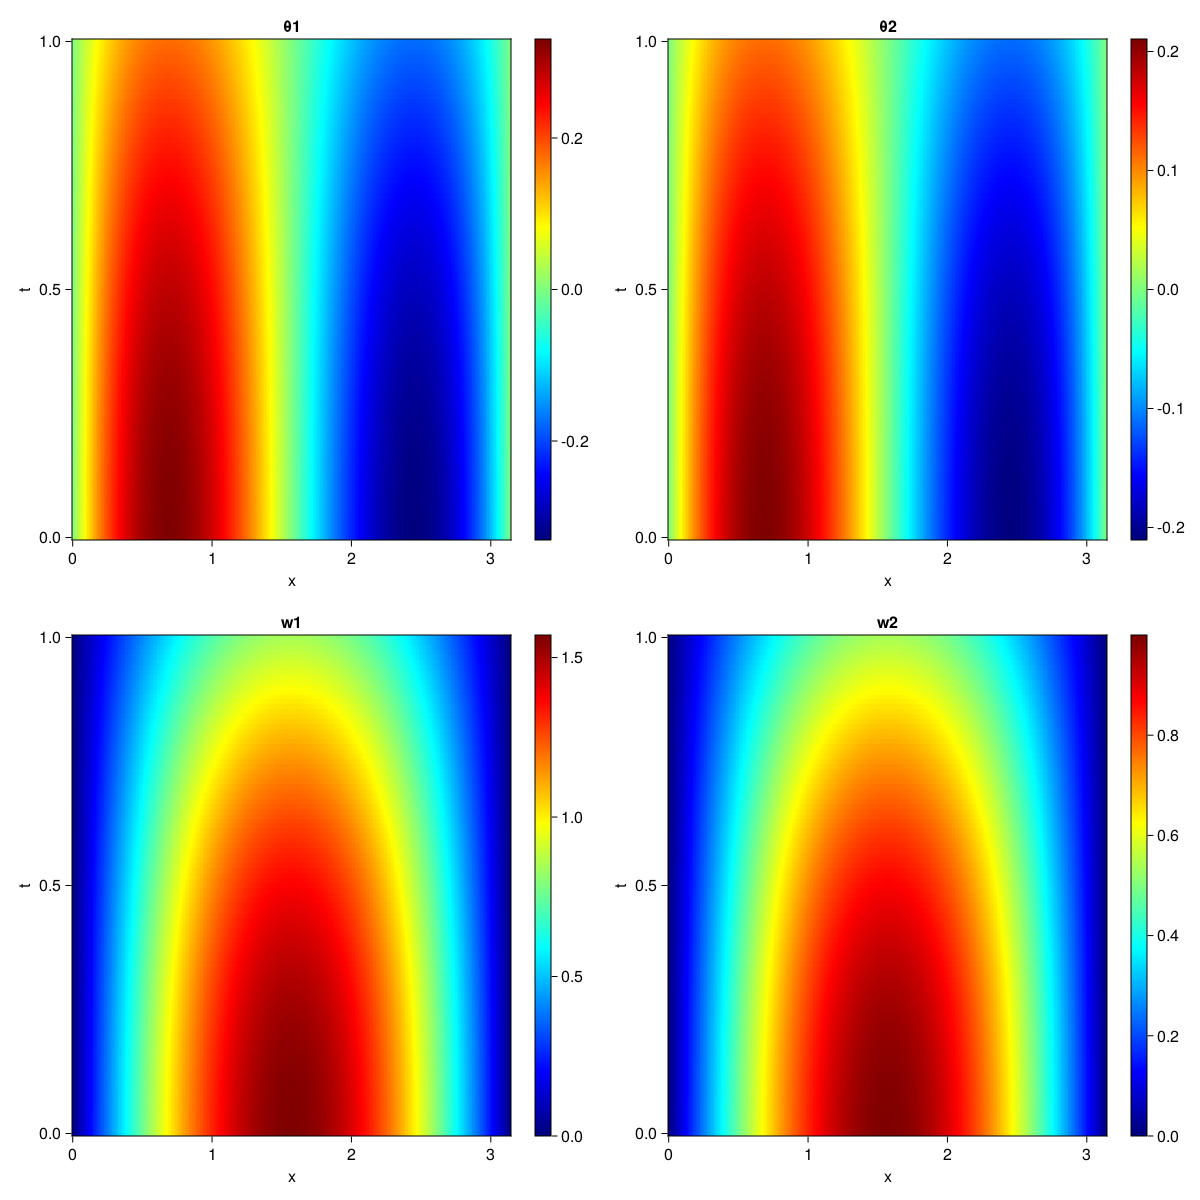

In [35]:
phi = pinn.phi
ps = res.u

xs, ts= [infimum(d.domain):0.01:supremum(d.domain) for d in timo_double.domain]


θ₁ = [sum(phi.θ₁(([x,t]), ps.θ₁)) for x in xs, t in ts]
θ₂ = [sum(phi.θ₂(([x,t]), ps.θ₂)) for x in xs, t in ts]
w₁ = [sum(phi.w₁(([x,t]), ps.w₁)) for x in xs, t in ts]
w₂ = [sum(phi.w₂(([x,t]), ps.w₂)) for x in xs, t in ts]

fig = Figure(resolution=(1200,1200))
axis = (xlabel="x", ylabel="t", title="f1")


_, hm3 = heatmap(fig[1, 1], xs, ts, θ₁, axis= merge(axis, (; title="θ1")), colormap=:jet)
Colorbar(fig[1, 2], hm3)
_, hm4 = heatmap(fig[1, 3], xs, ts, θ₂, axis= merge(axis, (; title="θ2")), colormap=:jet)
Colorbar(fig[1, 4], hm4)
_, hm5 = heatmap(fig[2, 1], xs, ts, w₁, axis= merge(axis, (; title="w1")), colormap=:jet)
Colorbar(fig[2, 2], hm5)
_, hm6 = heatmap(fig[2, 3], xs, ts, w₂, axis= merge(axis, (; title="w2")), colormap=:jet)
Colorbar(fig[2, 4], hm6)

display(fig)

In [21]:
θ₁_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t) 
θ₂_analytic(x,t) = (cos(x) + 2/π * x - 1)*cos(t)
w₁_analytic(x,t) = π/2*sin(x)*cos(t)
w₂_analytic(x,t) = sin(x)*cos(t)

w₂_analytic (generic function with 1 method)

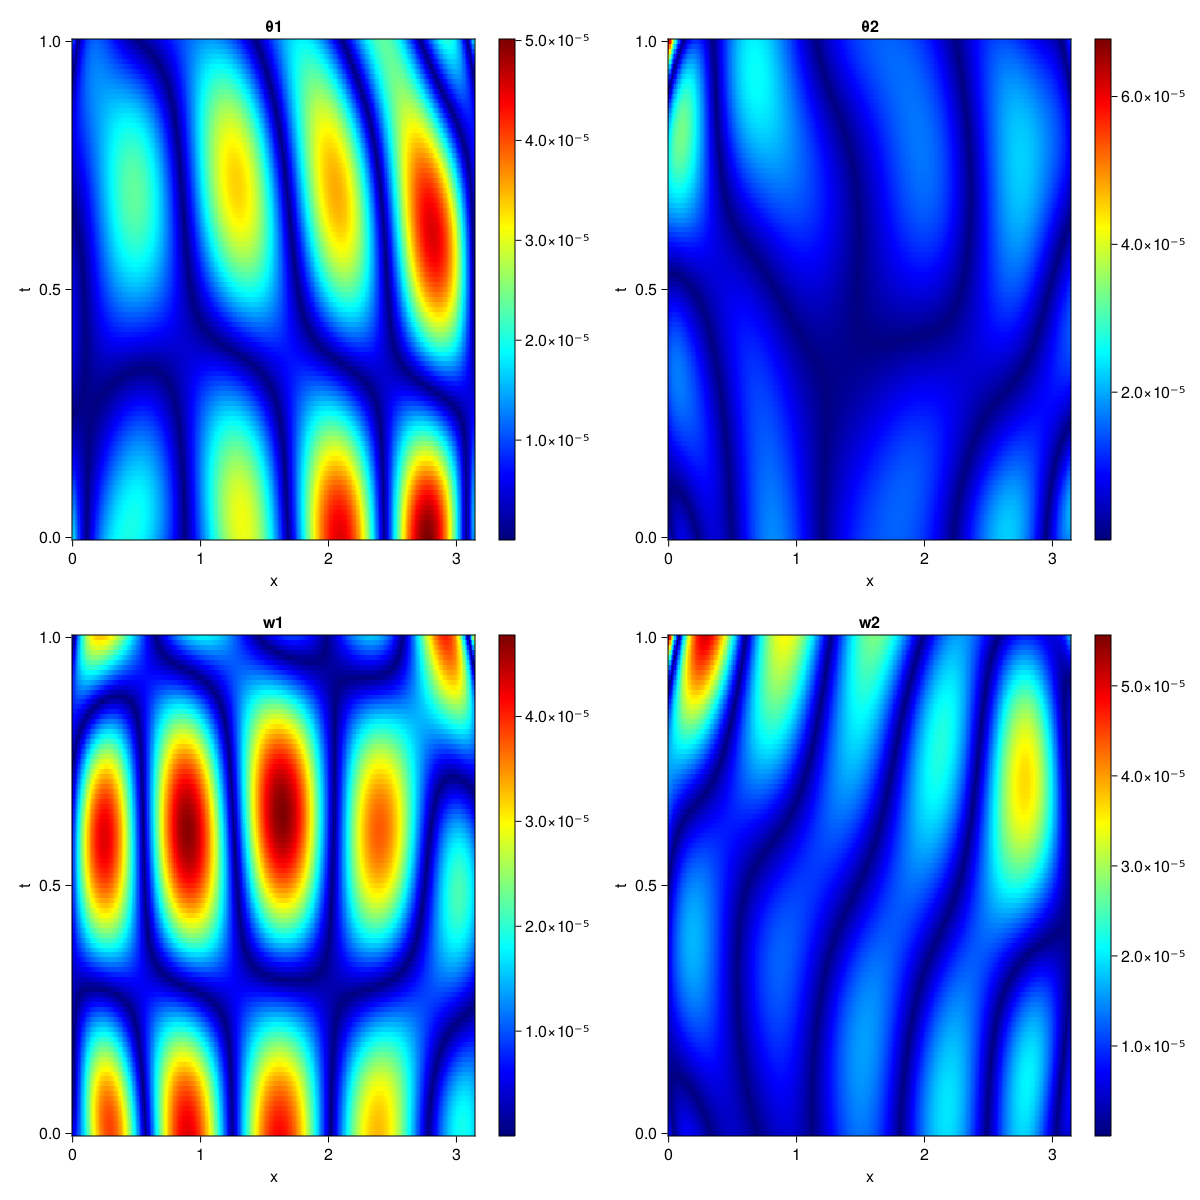

In [37]:
θ₁_true = [θ₁_analytic(x,t) for x in xs, t in ts]
θ₂_true = [θ₂_analytic(x,t) for x in xs, t in ts]
w₁_true = [w₁_analytic(x,t) for x in xs, t in ts]
w₂_true = [w₂_analytic(x,t) for x in xs, t in ts]

fig = Figure(resolution=(1200,1200))
axis = (xlabel="x", ylabel="t", title="f1 error")


_, hm3 = heatmap(fig[1, 1], xs, ts, abs.(θ₁ .- θ₁_true), axis= merge(axis, (; title="θ1")), colormap=:jet)
Colorbar(fig[1, 2], hm3)
_, hm4 = heatmap(fig[1, 3], xs, ts, abs.(θ₂ .- θ₂_true), axis= merge(axis, (; title="θ2")), colormap=:jet)
Colorbar(fig[1, 4], hm4)

_, hm5 = heatmap(fig[2, 1], xs, ts, abs.(w₁ .- w₁_true), axis= merge(axis, (; title="w1")), colormap=:jet)
Colorbar(fig[2, 2], hm5)
_, hm6 = heatmap(fig[2, 3], xs, ts, abs.(w₂ .- w₂_true), axis= merge(axis, (; title="w2")), colormap=:jet)
Colorbar(fig[2, 4], hm6)


display(fig)

In [ ]:
using JLD2

jldsave("timo_double_forward.jld2"; pde=timo, pinn=pinn, res=res, prob=prob)